In [1]:
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import metrics, model_selection as ms
from sklearn import ensemble, linear_model as lm, neural_network as nn
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn_pandas import DataFrameMapper

# Data preparation

In [2]:
train = pd.read_parquet('train.parquet')

Prepare `X` and `y` for modelling.

In [3]:
mapper = DataFrameMapper([
    ('amount_tsh', None),
    ('amount_tsh_is_zero', None),
    ('is_govt_funded', None),
    ('gps_height', None),
    (['longitude'], preprocessing.Imputer()),
    (['latitude'], preprocessing.Imputer()),
    ('num_private', None),
    ('num_private_is_zero', None),
    ('basin', ce.OneHotEncoder()),
    ('region', ce.OneHotEncoder()),
    ('population', None),
    ('population_is_zero', None),
    ('population_is_one', None),
    (['public_meeting'], preprocessing.Imputer()),
    (['permit'], preprocessing.Imputer()),
    (['construction_year'], preprocessing.Imputer()),
    (['age'], preprocessing.Imputer()),
    ('extraction_type', ce.OneHotEncoder()),
    ('management', ce.OneHotEncoder()),
    ('payment_type', ce.OneHotEncoder()),
    ('water_quality', ce.OneHotEncoder()),
    ('quantity', ce.OneHotEncoder()),
    ('source_type', ce.OneHotEncoder()),
    ('waterpoint_type', ce.OneHotEncoder()),
])

In [4]:
X = mapper.fit_transform(train)

In [5]:
X.shape

(59400, 118)

In [6]:
y = train['status_group']

Split the data into training/test and validation sets.

In [7]:
X_train, X_valid, y_train, y_valid = ms.train_test_split(X, y,
                                                         test_size=0.2,
                                                         random_state=42,
                                                         shuffle=True,
                                                         stratify=y)

Define a function to evaluate predictions.

In [8]:
def evaluate(y_true, y_pred):
    return {
        'accuracy': metrics.accuracy_score(y_true, y_pred),
        'confusion_matrix': metrics.confusion_matrix(y_true, y_pred),
    }

Define a cross-validation scheme for the training/test set.

In [9]:
cv = ms.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Modelling

## Regularised logistic regression

In [10]:
gs = ms.GridSearchCV(
    estimator=lm.LogisticRegression(),
    param_grid={
        'C': 10.**np.arange(-5, 6),
    },
    n_jobs=-1,
    cv=cv
)

In [11]:
gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [12]:
gs.best_estimator_

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

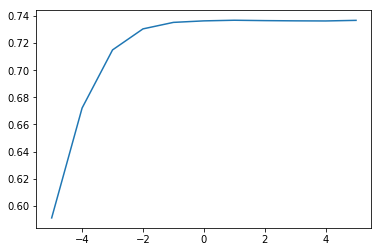

In [13]:
plt.plot(
    np.log10([params['C'] for params in gs.cv_results_['params']]),
    gs.cv_results_['mean_test_score']
)

In [14]:
evaluate(y_valid, gs.best_estimator_.predict(X_valid))

{'accuracy': 0.7395622895622895, 'confusion_matrix': array([[5824,    3,  625],
        [ 678,   11,  174],
        [1609,    5, 2951]])}

## Random forest

In [15]:
gs = ms.GridSearchCV(
    estimator=ensemble.RandomForestClassifier(min_samples_leaf=100, random_state=42),
    param_grid={
        'n_estimators': [5, 10, 20, 50, 100, 200, 500, 1000],
    },
    n_jobs=-1,
    cv=cv
)

In [16]:
gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=100, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [5, 10, 20, 50, 100, 200, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [17]:
gs.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=100, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

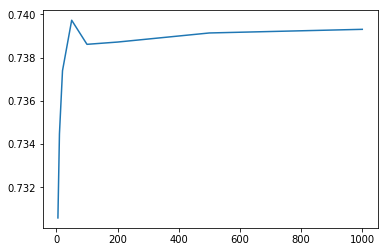

In [18]:
plt.plot(
    [params['n_estimators'] for params in gs.cv_results_['params']],
    gs.cv_results_['mean_test_score']
)

In [19]:
evaluate(y_valid, gs.best_estimator_.predict(X_valid))

{'accuracy': 0.7448653198653199, 'confusion_matrix': array([[6014,   10,  428],
        [ 699,   24,  140],
        [1749,    5, 2811]])}

## Multi-layer perceptron

In [20]:
scaled_mlp = Pipeline([
    ('scale', preprocessing.StandardScaler()),
    ('mlp', nn.MLPClassifier(activation='tanh', random_state=42))
])

In [21]:
gs = ms.GridSearchCV(
    estimator=scaled_mlp,
    param_grid={
        'mlp__alpha': 10.**np.arange(-6, 1),
    },
    n_jobs=-1,
    cv=cv
)

In [22]:
gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('mlp', MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate...       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'mlp__alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

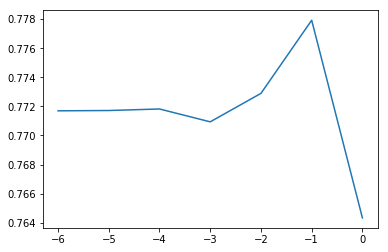

In [23]:
plt.plot(
    np.log10([params['mlp__alpha'] for params in gs.cv_results_['params']]),
    gs.cv_results_['mean_test_score']
)

In [24]:
evaluate(y_valid, gs.predict(X_valid))

{'accuracy': 0.7873737373737374, 'confusion_matrix': array([[5821,  100,  531],
        [ 538,  186,  139],
        [1161,   57, 3347]])}